# Description

Adapted from docs/dataflow/ck.run_batch_computation_dag.tutorial.ipynb

Build and run Mock2

# Imports

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as slmode

import core.artificial_signal_generators as carsigen
import core.config as cconfig
import core.features as cofeatur
import core.finance as cofinanc
import core.finance.market_data_example as cfmadaex
import core.signal_processing as csigproc
import dataflow.core as dtfcore
import dataflow.system as dtfsys
import helpers.hdbg as hdbg
import helpers.hprint as hprint

/app/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-41c41760-0074-4557-8b57-39253990b396.json'


# Build DAG

Build a `DagBuilder` object that defines a model's configuration
- `get_config_template()`: creates a configuration for each DAG Node
- `_get_dag()`: specifies all the DAG Nodes and builds a DAG using these Nodes

In [3]:
import dataflow_amp.pipelines.mock2.mock2_pipeline as dtapmmopi

dag_builder = dtapmmopi.Mock2_DagBuilder()
dag_config = dag_builder.get_config_template()
print(dag_config)

filter_weekends: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
  out_col_group: ()
  join_output_with_input: False
filter_ath: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    start_time: 09:30:00
    end_time: 16:00:00
  join_output_with_input: False
resample: 
  in_col_groups: [('open',), ('high',), ('low',), ('close',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    rule: 5T
    resampling_groups: [({'close': 'close'}, 'last', {}), ({'high': 'high'}, 'max', {}), ({'low': 'low'}, 'min', {}), ({'open': 'open'}, 'first', {}), ({'volume': 'volume'}, 'sum', {'min_count': 1}), ({'close': 'twap'}, 'mean', {})]
    vwap_groups: [('close', 'volume', 'vwap')]
  reindex_like_input: False
  join_output_with_input: False
compute_ret_0: 
  in_col_groups: [('close',), ('vwap',), ('twap',)]
  out_col_group: ()
  transformer_kwargs: 
    mode: pct_change
  col_mapping: 
    close: clo

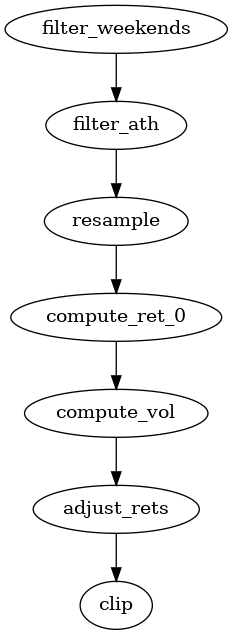

In [4]:
# Plot the model.
dag = dag_builder.get_dag(dag_config)
dtfcore.draw(dag)

# Add a node with data

## Build im_client

In [6]:
import im_v2.common.data.client.historical_pq_clients as imvcdchpcl

root_dir = "s3://cryptokaizen-data-test/v3/bulk"

im_client_config_dict = {
    "vendor": "bloomberg",
    "universe_version": "v1",
    "root_dir": root_dir,
    "partition_mode": "by_year_month",
    "dataset": "ohlcv",
    "contract_type": "spot",
    "data_snapshot": "",
    "download_mode": "manual",
    "downloading_entity": "",
    "aws_profile": "ck",
    "resample_1min": False,
    "version": "v1_0_0",
    "tag": "resampled_1min",
}

im_client = imvcdchpcl.HistoricalPqByCurrencyPairTileClient(**im_client_config_dict)

In [29]:
# Show how to read the raw data through the `ImClient`.
full_symbols = ["us_market::MSFT"]
start_ts = end_ts = None
columns = None
filter_data_mode = "assert"
datapull_data = im_client.read_data(full_symbols, start_ts, end_ts, columns, filter_data_mode)
display(datapull_data)

,full_symbol,open,high,low,close,volume,knowledge_timestamp
timestamp,,,,,,,
2023-08-01 00:01:00+00:00,us_market::MSFT,336.00,336.00,335.60,335.92,0.0,2023-09-26 16:16:04.623076+00:00
2023-08-01 00:02:00+00:00,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00
2023-08-01 00:03:00+00:00,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00
2023-08-01 00:04:00+00:00,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00
2023-08-01 00:05:00+00:00,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00
...,...,...,...,...,...,...,...
2023-08-31 23:26:00+00:00,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00
2023-08-31 23:27:00+00:00,us_market::MSFT,328.11,328.11,328.01,328.11,95.0,2023-09-26 16:16:04.623076+00:00
2023-08-31 23:28:00+00:00,us_market::MSFT,328.11,328.11,328.04,328.04,36.0,2023-09-26 16:16:04.623076+00:00


## Read universe

In [26]:
import dataflow.universe as dtfuniver

universe_str = "bloomberg_v1-top1"
full_symbols = dtfuniver.get_universe(universe_str)
asset_ids = im_client.get_asset_ids_from_full_symbols(full_symbols)

print(asset_ids)

[1343146433]


## Build market_data

In [30]:
import market_data as mdata

columns = None
columns_remap = None
market_data = mdata.get_HistoricalImClientMarketData_example1(
    im_client, asset_ids, columns, columns_remap
)

Object `market_data.get_data_for_interval()` not found.


In [35]:
# Print data in market data format.
timestamp_column_name = "end_ts"
tmp_data = market_data.get_data_for_interval(start_ts, end_ts, timestamp_column_name, asset_ids)
display(tmp_data)

,asset_id,full_symbol,open,high,low,close,volume,knowledge_timestamp,start_ts
end_ts,,,,,,,,,
2023-07-31 20:01:00-04:00,1343146433,us_market::MSFT,336.00,336.00,335.60,335.92,0.0,2023-09-26 16:16:04.623076+00:00,2023-07-31 20:00:00-04:00
2023-07-31 20:02:00-04:00,1343146433,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00,2023-07-31 20:01:00-04:00
2023-07-31 20:03:00-04:00,1343146433,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00,2023-07-31 20:02:00-04:00
2023-07-31 20:04:00-04:00,1343146433,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00,2023-07-31 20:03:00-04:00
2023-07-31 20:05:00-04:00,1343146433,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00,2023-07-31 20:04:00-04:00
...,...,...,...,...,...,...,...,...,...
2023-08-31 19:26:00-04:00,1343146433,us_market::MSFT,NaN,NaN,NaN,NaN,0.0,2023-09-26 16:16:04.623076+00:00,2023-08-31 19:25:00-04:00
2023-08-31 19:27:00-04:00,1343146433,us_market::MSFT,328.11,328.11,328.01,328.11,95.0,2023-09-26 16:16:04.623076+00:00,2023-08-31 19:26:00-04:00
2023-08-31 19:28:00-04:00,1343146433,us_market::MSFT,328.11,328.11,328.04,328.04,36.0,2023-09-26 16:16:04.623076+00:00,2023-08-31 19:27:00-04:00


## Build a HistoricalDataSource

In [19]:
stage = "read_data"
multiindex_output = True
col_names_to_remove = ["start_ts"]
timestamp_column_name = "end_ts"
node = dtfsys.HistoricalDataSource(
    stage,
    market_data,
    timestamp_column_name,
    multiindex_output,
    col_names_to_remove=col_names_to_remove,
)

In [37]:
# Data in dataflow format.
node.fit()["df_out"]

,close,full_symbol,high,knowledge_timestamp,low,open,volume
,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433
end_ts,,,,,,,
2023-07-31 20:01:00-04:00,335.92,us_market::MSFT,336.00,2023-09-26 16:16:04.623076+00:00,335.60,336.00,0.0
2023-07-31 20:02:00-04:00,NaN,us_market::MSFT,NaN,2023-09-26 16:16:04.623076+00:00,NaN,NaN,0.0
2023-07-31 20:03:00-04:00,NaN,us_market::MSFT,NaN,2023-09-26 16:16:04.623076+00:00,NaN,NaN,0.0
2023-07-31 20:04:00-04:00,NaN,us_market::MSFT,NaN,2023-09-26 16:16:04.623076+00:00,NaN,NaN,0.0
2023-07-31 20:05:00-04:00,NaN,us_market::MSFT,NaN,2023-09-26 16:16:04.623076+00:00,NaN,NaN,0.0
...,...,...,...,...,...,...,...
2023-08-31 19:26:00-04:00,NaN,us_market::MSFT,NaN,2023-09-26 16:16:04.623076+00:00,NaN,NaN,0.0
2023-08-31 19:27:00-04:00,328.11,us_market::MSFT,328.11,2023-09-26 16:16:04.623076+00:00,328.01,328.11,95.0


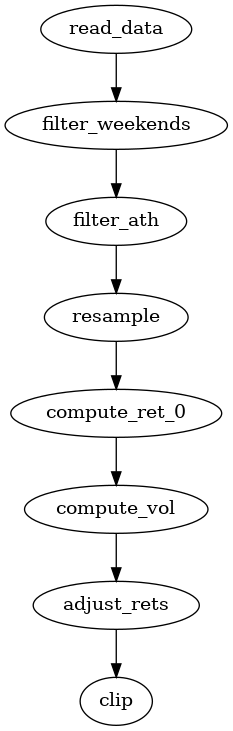

In [20]:
dag.insert_at_head(node)
dtfcore.draw(dag)

In [38]:
# Run the DAG.
dag_runner = dtfcore.FitPredictDagRunner(dag)
dag_runner.set_fit_intervals(
    [
        (
            tmp_data.index.min(),
            tmp_data.index.max(),
        )
    ],
)
fit_result_bundle = dag_runner.fit()
#
result_df = fit_result_bundle.result_df
result_df.head()

run_leq_node:   0%|          | 0/8 [00:00<?, ?it/s]

/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values
/app/core/signal_processing/ema_smoothing.py:65: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  signal_hat = signal_hat.ewm(
/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values
/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


,vwap.ret_0.vol_adj.c,vwap.ret_0.vol_adj,vwap.ret_0.vol,close.ret_0,twap.ret_0,vwap.ret_0,close,high,low,open,twap,volume,vwap
,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433
end_ts,,,,,,,,,,,,,
2023-07-31 20:05:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-31 20:10:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-31 20:15:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-31 20:20:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-31 20:25:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
result_df.dropna()

,vwap.ret_0.vol_adj.c,vwap.ret_0.vol_adj,vwap.ret_0.vol,close.ret_0,twap.ret_0,vwap.ret_0,close,high,low,open,twap,volume,vwap
,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433,1343146433
end_ts,,,,,,,,,,,,,
2023-08-01 09:50:00-04:00,-3.000000,-10.675958,0.001820,-0.001730,-0.001448,-0.001437,334.6500,335.5700,334.5700,335.23,334.88862,271801.0,334.892959
2023-08-01 09:55:00-04:00,-0.398166,-0.398166,0.001615,0.000149,-0.000855,-0.000793,334.7000,334.9163,334.3100,334.63,334.60222,274446.0,334.627469
2023-08-01 10:00:00-04:00,0.119231,0.119231,0.001437,-0.001165,0.000454,0.000217,334.3100,335.1800,334.0300,334.74,334.75400,345812.0,334.700069
2023-08-01 10:05:00-04:00,0.253326,0.253326,0.001312,0.002393,0.000436,0.000409,335.1099,335.3700,334.1900,334.27,334.89998,336312.0,334.837012
2023-08-01 10:10:00-04:00,0.521015,0.521015,0.001241,-0.000059,0.000591,0.000748,335.0900,335.3000,334.7891,335.11,335.09800,251544.0,335.087634
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 15:40:00-04:00,-0.262448,-0.262448,0.000589,0.000225,-0.000192,-0.000152,328.2400,328.3300,328.0000,328.26,328.15200,121801.0,328.163235
2023-08-31 15:45:00-04:00,1.667086,1.667086,0.000608,0.001249,0.000902,0.000998,328.6500,328.8500,328.1400,328.23,328.44800,239874.0,328.490896
